In [1]:
import sqlite3
import pandas as pd

# Conectando ao banco
conn = sqlite3.connect("usuarios.db")

# Lendo a tabela
df = pd.read_sql_query("SELECT * FROM usuarios", conn)

# Visualizando os dados
df.head()


,id,timestamp,despesa_mensal,tipo_trabalho,n_dependentes,valor_atual,meta,prazo_anos,aporte_atual,taxa_retorno_anual,reserva_ideal,aporte_necessario,tempo_estimado
0,a6747009-7776-45b1-85d7-8a13b6a09b19,2025-04-05T11:50:20.360499,5000.0,CLT,0,250000.0,1000000.0,3.0,2000.0,10.0,30000.0,23933.853861,9.3


<Axes: title={'center': 'Simulações por Tipo de Trabalho'}, xlabel='tipo_trabalho'>

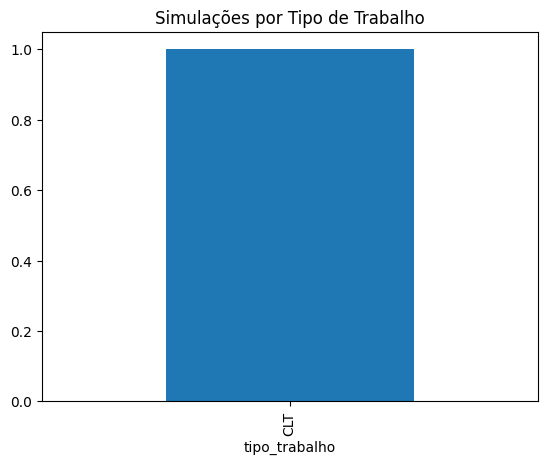

In [2]:
df['tipo_trabalho'].value_counts().plot(kind='bar', title="Simulações por Tipo de Trabalho")


<Axes: >

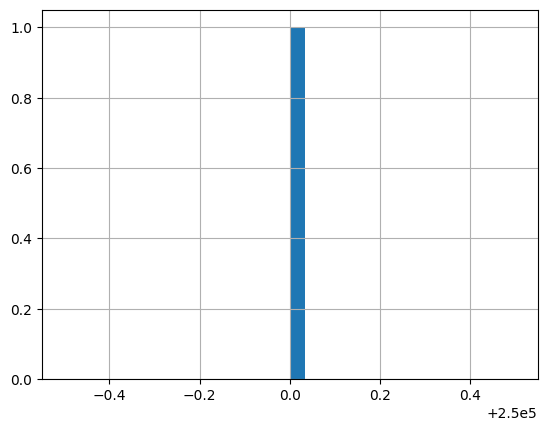

In [3]:
df['valor_atual'].hist(bins=30)


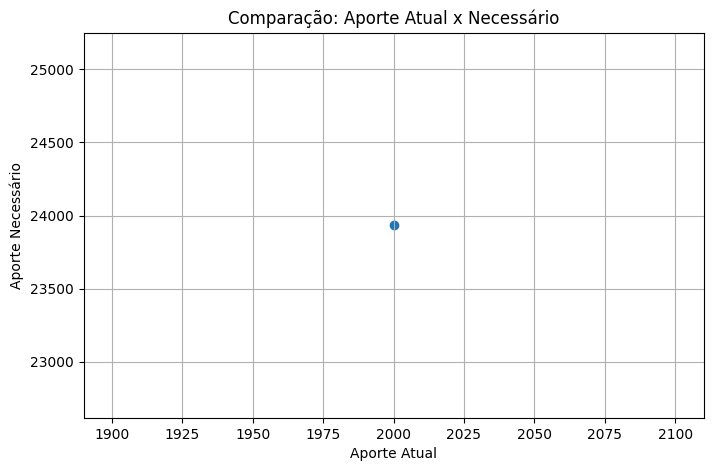

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(df['aporte_atual'], df['aporte_necessario'])
plt.xlabel('Aporte Atual')
plt.ylabel('Aporte Necessário')
plt.title('Comparação: Aporte Atual x Necessário')
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Prazo informado vs Tempo estimado')

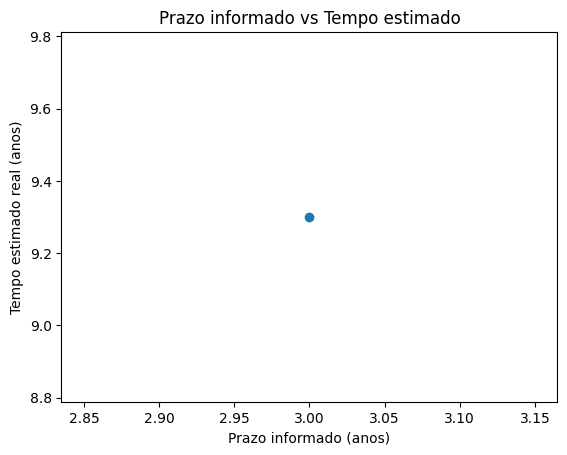

In [5]:
plt.scatter(df['prazo_anos'], df['tempo_estimado'])
plt.xlabel("Prazo informado (anos)")
plt.ylabel("Tempo estimado real (anos)")
plt.title("Prazo informado vs Tempo estimado")


In [6]:
df["atingiu_meta"] = df["tempo_estimado"] <= df["prazo_anos"]
df["atingiu_meta"].value_counts()


atingiu_meta
False    1
Name: count, dtype: int64